# Interactive napari pixel annotation on spatial proteomics

Harpy works with [SpatialData](https://spatialdata.scverse.org/en/stable/) and [AnnData](https://anndata.readthedocs.io/en/latest/) objects. This allows for interoperability with other libraries in the [scverse ecosystem](https://scverse.org/) that also work with these objects.

For interactive image analysis, a wide variety of [napari plugins](https://www.napari-hub.org/) are available. Pixel classifiers are a common tool for image analysis of highly-multiplexed images, as it allow useful summarization of multichannel images to one pixel map for a certain use case. This can be regular segmentation tasks like cell segmentation, but also tissue or blood vessel segmentation and cell type annotation. Note that it requires some **sparse manual annotation** to train the pixel classifier.
- For **instance segmentation**, you will need some extra postprocessing steps with other napari plugins as shown [here](https://guiwitz.github.io/napari-convpaint/book/Workflow.html).
- Note that this is not unsupervised clustering as in the [Pixie workflow of ark-analysis](https://github.com/angelolab/ark-analysis#2-pixel-clustering-with-pixie), but semi-supervised pixel classification. 
- Alternative pixel classifier workflows are [napari-APOC](https://haesleinhuepf.github.io/BioImageAnalysisNotebooks/20a_pixel_classification/multichannel_images.html) and QuPath's [Pixel classifier](https://qupath.readthedocs.io/en/latest/docs/tutorials/pixel_classification.html).

In this notebook, we load an artificial example dataset and perform pixel annotation using [napari-convpaint](https://github.com/guiwitz/napari-convpaint). We'll train a pixel classifier for three classes:
- Background and blue spots (channel 'nucleus')
- Red spots (channel 'lineage_5')
- Green spots (channel 'lineage_6')

The pixel map can be visualized within napari and saved back to the SpatialData object within the notebook.

In [1]:
# Install napari-convpaint as shown here https://github.com/guiwitz/napari-convpaint?tab=readme-ov-file#installation
# e.g. pip install napari-convpaint

In [2]:
# load some example SpatialData
from sparrow.datasets import multisample_blobs

sdata = multisample_blobs(n_samples=1)
sdata

the value of the environment variable BASIC_DCT_BACKEND is not in ["JAX","SCIPY"]


INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           
INFO     no axes information specified in the object, setting `dims` to: ('y', 'x')                                


/opt/homebrew/Caskroom/mambaforge/base/envs/harpy/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/homebrew/Caskroom/mambaforge/base/envs/harpy/lib/python3.10/site-packages/spatialdata/models/models.py:1018: UserWarning: Converting `region_key: region` to categorical dtype.
  return convert_region_column_to_categorical(adata)
/opt/homebrew/Caskroom/mambaforge/base/envs/harpy/lib/python3.10/site-packages/spatialdata/_core/_elements.py:116: UserWarning: Key `sample_0_table` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


SpatialData object
├── Images
│     └── 'sample_0_image': DataArray[cyx] (11, 512, 512)
├── Labels
│     └── 'sample_0_labels': DataArray[yx] (512, 512)
├── Points
│     └── 'sample_0_points': DataFrame with shape: (<Delayed>, 2) (2D points)
└── Tables
      ├── 'sample_0_table': AnnData (20, 11)
      └── 'table': AnnData (20, 11)
with coordinate systems:
    ▸ 'sample_0', with elements:
        sample_0_image (Images), sample_0_labels (Labels), sample_0_points (Points)

Here we set the Image layers to be used in napari. We need to add the channels as separate layers, so we can control the visibility of each channel. For the pixel classifiers itself, we will add the multichannel image as a single 'stacked' layer. The model is trained on the multichannel image, the separate channels are used for visualization during annotation.

In [3]:
import napari
from napari.utils.notebook_display import nbscreenshot

viewer = napari.Viewer()

In [4]:
for l in viewer.layers:
    viewer.layers.remove(l)

image = sdata["sample_0_image"]

for c in image.coords["c"].values:
    viewer.add_image(image.sel(c=c).data, name=c)

viewer.add_image(image.data, name="stack")

<Image layer 'stack' at 0x37f0e3010>

In [5]:
for _i, layer in enumerate(viewer.layers):
    layer.visible = False
    layer.colormap = "gray_r"
    layer.blending = "minimum"

config = {
    "nucleus": (True, "I Blue", (50, 300)),
    "lineage_5": (True, "I Forest", (50, 70)),
    "lineage_6": (True, "I Bordeaux", (50, 200)),
}

for channel, (visible, colormap, limits) in config.items():
    viewer.layers[channel].visible = visible
    viewer.layers[channel].colormap = colormap
    viewer.layers[channel].contrast_limits = limits

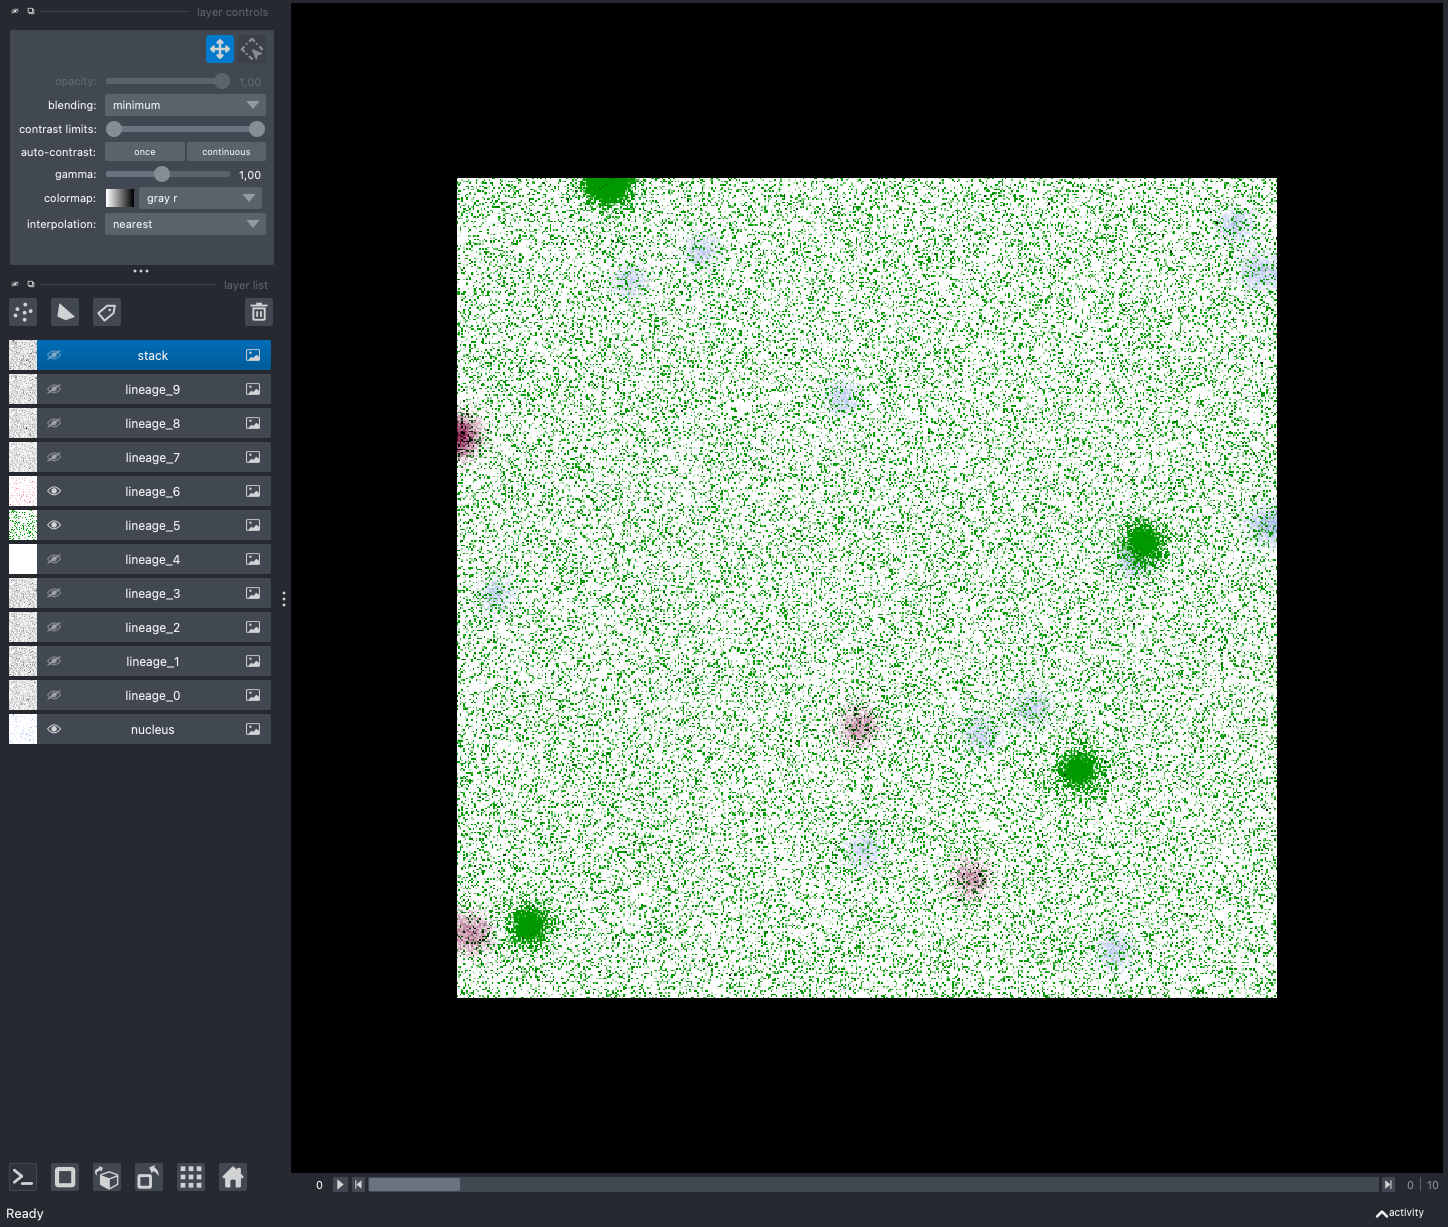

In [6]:
# load the plugin if it is installed, you can also open it from napari using the Plugins menu
# _,_ = viewer.window.add_plugin_dock_widget('napari-convpaint') # open the napari-convpaint plugin
nbscreenshot(viewer)

Napari opens in a new window. The workflow can be found [here](https://guiwitz.github.io/napari-convpaint/book/IMC_data.html) and is as follows:

- In the new widget window on the right, select as `Layer to segment` the `stack` layer. For `Layer for annotation`, select the `annotations` layer and make sure it's selected on the left.
- Set `Data dimensions` to `Multichannel image`.
- Use the brush tool on the top left to annotate the image and set the label to 1.
  - Draw some annotations on the background and blue spots.
  - Set the label to 2 and draw some annotations on the red spots.
  - Set the label to 3 and draw some annotations on the green spots.
- Click on `Train model`.
- Click on `Segment` to apply the model to the image.
- You can change the visibility of the layers `segmentations` on the left.
- Annotate some more if needed, and keep training and segmenting to evaluate the results.

After annotation, the labels will be saved in `segmentation` layer and can be saved back to the SpatialData object, as shown in the code below. Also save the `annotations` layer, as it contains the training data.

In [7]:
# Add empty layers just for the sake of the example, remove this in your own code
if "annotations" not in viewer.layers:
    import numpy as np

    viewer.add_labels(name="annotations", data=np.zeros(image.shape[1:], dtype=np.uint8))
    viewer.add_labels(name="segmentation", data=np.zeros(image.shape[1:], dtype=np.uint8))
# Here the segmentation layer will be empty because there is no annotation yet
annotation_layer = viewer.layers["annotations"]
pixel_map_layer = viewer.layers["segmentation"]
pixel_map_layer.data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [8]:
import spatialdata as sd

In [9]:
annotation_el = sd.models.Labels2DModel.parse(
    annotation_layer.data, transformations={"sample_0": sd.transformations.Identity()}
)
pixel_map_el = sd.models.Labels2DModel.parse(
    pixel_map_layer.data, transformations={"sample_0": sd.transformations.Identity()}
)
pixel_map_el

INFO     no axes information specified in the object, setting `dims` to: ('y', 'x')                                
INFO     no axes information specified in the object, setting `dims` to: ('y', 'x')                                


<xarray.DataArray 'image' (y: 512, x: 512)> Size: 262kB
dask.array<array, shape=(512, 512), dtype=uint8, chunksize=(512, 512), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 4kB 0.5 1.5 2.5 3.5 4.5 ... 508.5 509.5 510.5 511.5
  * x        (x) float64 4kB 0.5 1.5 2.5 3.5 4.5 ... 508.5 509.5 510.5 511.5
Attributes:
    transform:  {'sample_0': Identity }

In [10]:
sdata.labels["sample_0_annotation_labels"] = annotation_el
sdata.labels["sample_0_pixel_map_labels"] = pixel_map_el
sdata

SpatialData object
├── Images
│     └── 'sample_0_image': DataArray[cyx] (11, 512, 512)
├── Labels
│     ├── 'sample_0_annotation_labels': DataArray[yx] (512, 512)
│     ├── 'sample_0_labels': DataArray[yx] (512, 512)
│     └── 'sample_0_pixel_map_labels': DataArray[yx] (512, 512)
├── Points
│     └── 'sample_0_points': DataFrame with shape: (<Delayed>, 2) (2D points)
└── Tables
      ├── 'sample_0_table': AnnData (20, 11)
      └── 'table': AnnData (20, 11)
with coordinate systems:
    ▸ 'sample_0', with elements:
        sample_0_image (Images), sample_0_annotation_labels (Labels), sample_0_labels (Labels), sample_0_pixel_map_labels (Labels), sample_0_points (Points)

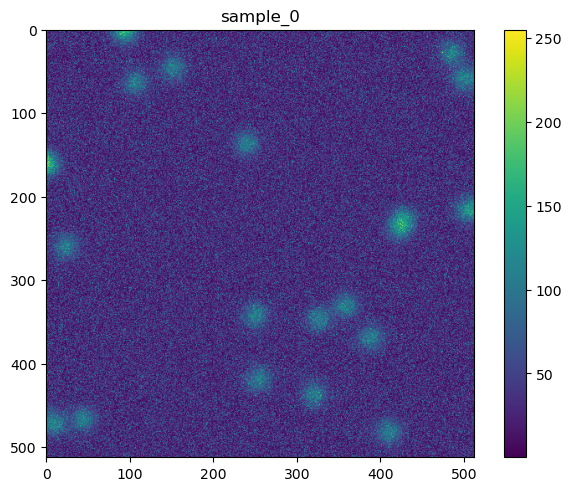

In [11]:
(
    sdata.pl.render_images(channel="nucleus")
    # note that the pixel map will be empty if no annotations have been made
    .pl.render_labels(element="sample_0_pixel_map_labels")
    .pl.show()
)